In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [137]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [146]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
import requests
from bs4 import BeautifulSoup

In [3]:
from geopy.geocoders import Nominatim
import folium

In [4]:
import sys,os.path
import re

In [5]:
SFO_FILE = "/var/tmp/sfo_wiki.txt"
NYC_FILE = "/var/tmp/nyc_wiki.txt"

In [6]:
# scrape SFO wiki for neighborhoods

if (os.path.exists(SFO_FILE) and os.path.getsize(SFO_FILE)):
    #read from file instead of the net
    print("reading sfo wiki from file")
    with open(SFO_FILE) as rsf:
        sfo_text = rsf.read()
else:
    print("reading sfo wiki from net")
    sfo_wiki = requests.get("https://en.wikipedia.org/wiki/List_of_neighborhoods_in_San_Francisco")
    if sfo_wiki.ok:
        #write it to file
        sfo_text = sfo_wiki.text
        with open(SFO_FILE, "w") as wsf:
            wsf.write(sfo_wiki.text)
    else:
        sys.exit("error reading wiki!")

reading sfo wiki from file


In [7]:
# scrape NYC wiki for neighborhoods

if (os.path.exists(NYC_FILE) and os.path.getsize(NYC_FILE)):
    #read from file instead of the net
    print("reading nyc wiki from file")
    with open(NYC_FILE) as rny:
        nyc_text = rny.read()
else:
    print("reading nyc wiki from net")
    nyc_wiki = requests.get("https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City")
    if nyc_wiki.ok:
        #write it to file
        nyc_text = nyc_wiki.text
        with open(NYC_FILE, "w") as wny:
            wny.write(nyc_wiki.text)
    else:
        sys.exit("error reading wiki!")

reading nyc wiki from file


In [8]:
sfo_soup = BeautifulSoup(sfo_text, "lxml")

nyc_soup = BeautifulSoup(nyc_text, "lxml")

In [9]:
# begin - process SFO data

sfo_neigh = sfo_soup.find_all('span',class_="toctext")

In [10]:
sfo_neighborhoods = []
for n in sfo_neigh:
    sfo_neighborhoods.append(n.string)
print("count is: ",len(sfo_neighborhoods))

count is:  123


In [11]:
sfo_neighborhoods[0:5]

['Alamo Square',
 'Anza Vista',
 'Ashbury Heights',
 'Balboa Park',
 'Balboa Terrace']

In [12]:
sfo_neighborhoods[-5:]

['Yerba Buena',
 'See also',
 'References',
 'External links',
 'Specific neighborhoods']

In [13]:
sfo_neighborhoods = sfo_neighborhoods[:-4]

In [14]:
len(sfo_neighborhoods)

119

In [15]:
# end - process SFO wiki data

sfo_neighborhoods[-5:]

['West Portal',
 'Western Addition',
 'Westwood Highlands',
 'Westwood Park',
 'Yerba Buena']

In [16]:
# begin - process NYC wiki data

nyc_rows = nyc_soup.select("table.wikitable.sortable > tbody > tr > td:nth-of-type(5) > a")

In [17]:
type(nyc_rows)

list

In [18]:
nyc_rows[:5]

[<a href="/wiki/Melrose,_Bronx" title="Melrose, Bronx">Melrose</a>,
 <a href="/wiki/Mott_Haven,_Bronx" title="Mott Haven, Bronx">Mott Haven</a>,
 <a href="/wiki/Port_Morris,_Bronx" title="Port Morris, Bronx">Port Morris</a>,
 <a href="/wiki/Hunts_Point,_Bronx" title="Hunts Point, Bronx">Hunts Point</a>,
 <a href="/wiki/Longwood,_Bronx" title="Longwood, Bronx">Longwood</a>]

In [19]:
nyc_rows[-5:]

[<a href="/wiki/Prince%27s_Bay,_Staten_Island" title="Prince's Bay, Staten Island">Prince's Bay</a>,
 <a href="/wiki/Richmond_Valley,_Staten_Island" title="Richmond Valley, Staten Island">Richmond Valley</a>,
 <a href="/wiki/Rossville,_Staten_Island" title="Rossville, Staten Island">Rossville</a>,
 <a href="/wiki/Tottenville,_Staten_Island" title="Tottenville, Staten Island">Tottenville</a>,
 <a href="/wiki/Woodrow,_Staten_Island" title="Woodrow, Staten Island">Woodrow</a>]

In [20]:
nyc_neighborhoods = []
for row in nyc_rows:
    neighs = [str(x).strip() for x in str(row.string).split(',')]
    nyc_neighborhoods.extend(neighs)

In [21]:
nyc_neighborhoods[0:5]

['Melrose', 'Mott Haven', 'Port Morris', 'Hunts Point', 'Longwood']

In [22]:
nyc_neighborhoods[-5:]

["Prince's Bay", 'Richmond Valley', 'Rossville', 'Tottenville', 'Woodrow']

In [23]:
# end - process NYC wiki data

len(nyc_neighborhoods)

328

In [24]:
# get NYC lats & lngs

geolocator = Nominatim(user_agent="nyc_sfo_explorer")

In [25]:
dfny_file = "/var/tmp/nyc2_df.csv"
dfsf_file = "/var/tmp/sfo2_df.csv"

In [26]:
if not os.path.exists(dfny_file):
    
    print('getting lats & lngs from net')
    lats = []
    lngs = []
    neighs = []
    missing_ny_neighs = []
    
    for loc in nyc_neighborhoods:
            addr = loc + ", New York, NY"
            #print("addr: ", addr)
            location = geolocator.geocode(addr)
            if (location is not None):
                lat = location.latitude
                lng = location.longitude
                #print("addr {} is at lat: {}, lng: {}".format(addr, lat,lng))
                lats.append(lat)
                lngs.append(lng)
                neighs.append(loc)
            else:
                #print("could not find geocode for {}".format(loc))
                missing_ny_neighs.append(loc)
                
    dfny = pd.DataFrame(list(zip(neighs,lats,lngs)), columns=['Neighborhood', 'Latitude', 'Longitude'])
    dfny.to_csv(dfny_file, index=False)
    
else:
    print('getting lats & lngs from disk')
    dfny = pd.read_csv(dfny_file)

getting lats & lngs from disk


In [27]:
dfny.shape

(314, 3)

In [28]:
dfny.head()

,Neighborhood,Latitude,Longitude
0,Melrose,40.824545,-73.910414
1,Mott Haven,40.808990,-73.922915
2,Port Morris,40.801515,-73.909581
3,Hunts Point,40.812601,-73.884025
4,Longwood,42.953115,-78.369465


In [29]:
dfny.tail()

,Neighborhood,Latitude,Longitude
309,Prince's Bay,40.528994,-74.197644
310,Richmond Valley,40.520105,-74.229311
311,Rossville,40.555624,-74.212898
312,Tottenville,40.511217,-74.249312
313,Woodrow,40.543439,-74.197644


In [30]:
dfny.describe()

,Latitude,Longitude
count,314.000000,314.000000
mean,40.927502,-74.102143
std,0.684101,0.853240
min,40.511217,-78.799202
25%,40.637197,-74.006881
50%,40.728297,-73.941158
75%,40.824445,-73.852635
max,44.751610,-72.173984


In [31]:
# begin - NYC data clean up 
dfny.drop_duplicates(keep='first', inplace=True)

In [32]:
# clean up outliers - likely from the geocoder not getting the address right

# Lngs IQR
ny_lng_Q1 = dfny['Longitude'].quantile(.25)
ny_lng_Q3 = dfny['Longitude'].quantile(.75)
ny_lng_IQR = ny_lng_Q3 - ny_lng_Q1

# Lats IQR
ny_lat_Q1 = dfny['Latitude'].quantile(.25)
ny_lat_Q3 = dfny['Latitude'].quantile(.75)
ny_lat_IQR = ny_lat_Q3 - ny_lat_Q1

In [33]:
# drop longitude outliers

dfny.drop(dfny[(dfny['Longitude'] > (ny_lng_Q3 + 1.5 * ny_lng_IQR)) | (dfny['Longitude'] < (ny_lng_Q1 - 1.5 * ny_lng_IQR))].index, axis=0, inplace=True)

In [34]:
# drop latitide outliers

dfny.drop(dfny[(dfny['Latitude'] > (ny_lat_Q3 + 1.5 * ny_lat_IQR)) | (dfny['Latitude'] < (ny_lat_Q1 - 1.5 * ny_lat_IQR))].index, axis=0, inplace=True)

In [35]:
# remove Bronx River neighborhood from the listing. wrong data from wiki ...

dfny.drop(dfny[dfny['Neighborhood'] == 'Bronx River'].index, inplace=True)

In [36]:
dfny.head()

,Neighborhood,Latitude,Longitude
0,Melrose,40.824545,-73.910414
1,Mott Haven,40.808990,-73.922915
2,Port Morris,40.801515,-73.909581
3,Hunts Point,40.812601,-73.884025
5,Claremont,40.839876,-73.907328


In [37]:
dfny.tail()

,Neighborhood,Latitude,Longitude
308,Pleasant Plains,40.523994,-74.215700
309,Prince's Bay,40.528994,-74.197644
310,Richmond Valley,40.520105,-74.229311
311,Rossville,40.555624,-74.212898
313,Woodrow,40.543439,-74.197644


In [38]:
dfny.reset_index(drop=True, inplace=True)

In [39]:
# end - NYC data clean up

dfny.shape

(255, 3)

In [40]:
# begin - NYC merge neighborhoods with similar lats & lngs

dfgny = dfny.groupby(['Latitude', 'Longitude'], as_index=False).agg({'Neighborhood': lambda x: ','.join(x)})

In [41]:
dfgny.tail()

,Latitude,Longitude,Neighborhood
245,40.894444,-73.903333,Fieldston
246,40.897877,-73.852357,Wakefield
247,40.898155,-73.867357,Woodlawn
248,40.900560,-73.906390,Riverdale
249,40.909821,-73.807911,Pelham Gardens


In [42]:
dfgny.loc[dfgny['Neighborhood'].str.contains(r'(Grave|Astoria|Corona|Flushing|Jamaica)')]

/Users/sudhirc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,Latitude,Longitude,Neighborhood
36,40.596134,-73.973943,"Gravesend,East Gravesend"
108,40.691485,-73.805677,"Jamaica,South Jamaica"
114,40.702185,-73.936434,"Flushing South,East Flushing"
124,40.713322,-73.782506,Jamaica Estates
160,40.744181,-73.835854,Flushing
162,40.746959,-73.860146,"North Corona,Corona"
181,40.772015,-73.930267,"Astoria,Old Astoria"


In [43]:
type(dfgny)

pandas.core.frame.DataFrame

In [44]:
dfgny.columns

Index(['Latitude', 'Longitude', 'Neighborhood'], dtype='object')

In [45]:
# end - NYC merge

dfg_nyc = dfgny[['Neighborhood','Latitude', 'Longitude']]

In [46]:
# begin - NYC map lats & lngs

nyc_addr = "New York, NY"
nyc_loc = geolocator.geocode(nyc_addr)
nyc_lat = nyc_loc.latitude
nyc_lng = nyc_loc.longitude

In [47]:
map_nyc = folium.Map(location=[nyc_lat, nyc_lng], zoom_start=10)

In [48]:
# adding markers for the neighborhoods on the map
for lat, lng, neighborhood in zip(dfg_nyc['Latitude'], dfg_nyc['Longitude'], dfg_nyc['Neighborhood']):
    label = '{}'.format(neighborhood) 
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc', fill_opacity=0.7, parse_html=False).add_to(map_nyc)

In [49]:
# end - NYC map
map_nyc

In [50]:
# begin - SFO get lats & lngs

if not os.path.exists(dfsf_file):
    
    print('getting lats & lngs from net')
    lats = []
    lngs = []
    neighs = []
    missing_sf_neighs = []
    
    for loc in sfo_neighborhoods:
            addr = loc + ", San Francisco, CA"
            #print("addr: ", addr)
            location = geolocator.geocode(addr)
            if (location is not None):
                lat = location.latitude
                lng = location.longitude
                #print("addr {} is at lat: {}, lng: {}".format(addr, lat,lng))
                lats.append(lat)
                lngs.append(lng)
                neighs.append(loc)
            else:
                #print("could not find geocode for {}".format(loc))
                missing_sf_neighs.append(loc)
                
    dfsf = pd.DataFrame(list(zip(neighs,lats,lngs)), columns=['Neighborhood', 'Latitude', 'Longitude'])
    dfsf.to_csv(dfsf_file, index=False)
    
else:
    print('getting lats & lngs from disk')
    dfsf = pd.read_csv(dfsf_file)

getting lats & lngs from disk


In [51]:
dfsf.shape

(83, 3)

In [52]:
dfsf.iloc[0:5]

,Neighborhood,Latitude,Longitude
0,Alamo Square,37.776357,-122.434694
1,Anza Vista,37.780836,-122.443149
2,Balboa Park,37.724949,-122.444805
3,Bayview,37.728889,-122.392500
4,Belden Place,37.791744,-122.403886


In [53]:
# end - SFO get lats & lngs
dfsf.iloc[-5:]

,Neighborhood,Latitude,Longitude
78,Union Square,37.787936,-122.407517
79,Visitacion Valley,37.712132,-122.409713
80,West Portal,37.741141,-122.465634
81,Western Addition,37.779559,-122.429810
82,Yerba Buena,-5.735634,-79.043992


In [54]:
# begin - SFO data clean up

dfsf.drop_duplicates(keep='first', inplace=True)

In [55]:
# clean up outliers - likely from the geocoder not getting the address right

# Lngs IQR
sf_lng_Q1 = dfsf['Longitude'].quantile(.25)
sf_lng_Q3 = dfsf['Longitude'].quantile(.75)
sf_lng_IQR = sf_lng_Q3 - sf_lng_Q1

# Lats IQR
sf_lat_Q1 = dfsf['Latitude'].quantile(.25)
sf_lat_Q3 = dfsf['Latitude'].quantile(.75)
sf_lat_IQR = sf_lat_Q3 - sf_lat_Q1

In [56]:
# drop longitude outliers

dfsf.drop(dfsf[(dfsf['Longitude'] > (sf_lng_Q3 + 1.5 * sf_lng_IQR)) | (dfsf['Longitude'] < (sf_lng_Q1 - 1.5 * sf_lng_IQR))].index, axis=0, inplace=True)

In [57]:
# drop latitide outliers

dfsf.drop(dfsf[(dfsf['Latitude'] > (sf_lat_Q3 + 1.5 * sf_lat_IQR)) | (dfsf['Latitude'] < (sf_lat_Q1 - 1.5 * sf_lat_IQR))].index, axis=0, inplace=True)

In [58]:
dfsf.head()

,Neighborhood,Latitude,Longitude
0,Alamo Square,37.776357,-122.434694
1,Anza Vista,37.780836,-122.443149
2,Balboa Park,37.724949,-122.444805
3,Bayview,37.728889,-122.392500
4,Belden Place,37.791744,-122.403886


In [59]:
dfsf.tail()

,Neighborhood,Latitude,Longitude
77,Twin Peaks,37.754640,-122.446480
78,Union Square,37.787936,-122.407517
79,Visitacion Valley,37.712132,-122.409713
80,West Portal,37.741141,-122.465634
81,Western Addition,37.779559,-122.429810


In [60]:
dfsf.reset_index(drop=True, inplace=True)

In [61]:
# merge neighborhoods with similar lats & lngs

dfgsf = dfsf.groupby(['Latitude', 'Longitude'], as_index=False).agg({'Neighborhood': lambda x: ','.join(x)})

In [62]:
dfgsf.shape

(79, 3)

In [63]:
dfgsf.tail()

,Latitude,Longitude,Neighborhood
74,37.802730,-122.405851,Telegraph Hill
75,37.802984,-122.437472,Marina District
76,37.806532,-122.420649,Buena Vista
77,37.809167,-122.416599,Fisherman's Wharf
78,37.823354,-122.370153,Treasure Island


In [64]:
dfgsf.loc[dfgsf['Neighborhood'].str.contains(r'(Portola|Financial)')]

/Users/sudhirc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,Latitude,Longitude,Neighborhood
8,37.726379,-122.408551,"Portola,Portola Place"
68,37.793647,-122.398938,"Financial District,Financial District South"


In [65]:
dfgsf.columns

Index(['Latitude', 'Longitude', 'Neighborhood'], dtype='object')

In [66]:
dfg_sfo = dfgsf[['Neighborhood','Latitude', 'Longitude']]

In [67]:
# end - SFO clean up and merge
dfg_sfo.shape

(79, 3)

In [68]:
sfo_addr = "San Francisco, CA"
sfo_loc = geolocator.geocode(sfo_addr)
sfo_lat = sfo_loc.latitude
sfo_lng = sfo_loc.longitude

In [69]:
map_sfo = folium.Map(location=[sfo_lat, sfo_lng], zoom_start=10)

In [70]:
# adding markers for the neighborhoods on the map
for lat, lng, neighborhood in zip(dfg_sfo['Latitude'], dfg_sfo['Longitude'], dfg_sfo['Neighborhood']):
    label = '{}'.format(neighborhood) 
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc', fill_opacity=0.7, parse_html=False).add_to(map_sfo)

In [71]:
map_sfo

In [72]:
# combine NYC and SFO into a dataframe ; add city column

dfg_sfo.head()

,Neighborhood,Latitude,Longitude
0,Crocker-Amazon,37.709378,-122.438587
1,Sunnydale,37.709519,-122.404779
2,Visitacion Valley,37.712132,-122.409713
3,Oceanview,37.713651,-122.457483
4,Parkmerced,37.717176,-122.478947


In [73]:
dfg_nyc.head()

,Neighborhood,Latitude,Longitude
0,Richmond Valley,40.520105,-74.229311
1,Pleasant Plains,40.523994,-74.215700
2,Prince's Bay,40.528994,-74.197644
3,Charleston,40.536772,-74.237367
4,Huguenot,40.537328,-74.194588


In [74]:
dfg_nyc['City'] = 'New York'

/Users/sudhirc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [75]:
dfg_nyc.head()

,Neighborhood,Latitude,Longitude,City
0,Richmond Valley,40.520105,-74.229311,New York
1,Pleasant Plains,40.523994,-74.215700,New York
2,Prince's Bay,40.528994,-74.197644,New York
3,Charleston,40.536772,-74.237367,New York
4,Huguenot,40.537328,-74.194588,New York


In [76]:
dfg_sfo['City'] = 'San Francisco'

/Users/sudhirc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [77]:
dfg_sfo.head()

,Neighborhood,Latitude,Longitude,City
0,Crocker-Amazon,37.709378,-122.438587,San Francisco
1,Sunnydale,37.709519,-122.404779,San Francisco
2,Visitacion Valley,37.712132,-122.409713,San Francisco
3,Oceanview,37.713651,-122.457483,San Francisco
4,Parkmerced,37.717176,-122.478947,San Francisco


In [78]:
dfg_sfo.shape

(79, 4)

In [79]:
dfg_nyc.shape

(250, 4)

In [80]:
# combine and sfo and nyc dataframes

df = pd.concat([dfg_nyc, dfg_sfo], ignore_index=True)

In [81]:
df.shape

(329, 4)

In [82]:
df.head()

,Neighborhood,Latitude,Longitude,City
0,Richmond Valley,40.520105,-74.229311,New York
1,Pleasant Plains,40.523994,-74.215700,New York
2,Prince's Bay,40.528994,-74.197644,New York
3,Charleston,40.536772,-74.237367,New York
4,Huguenot,40.537328,-74.194588,New York


In [83]:
df.tail()

,Neighborhood,Latitude,Longitude,City
324,Telegraph Hill,37.802730,-122.405851,San Francisco
325,Marina District,37.802984,-122.437472,San Francisco
326,Buena Vista,37.806532,-122.420649,San Francisco
327,Fisherman's Wharf,37.809167,-122.416599,San Francisco
328,Treasure Island,37.823354,-122.370153,San Francisco


In [84]:
# begin - get Foursquare data

# 4square creds hidden


In [101]:
# test data for one neighborhood

VERSION='20180604'
RADIUS=500
LIMIT=100
neighborhood_latitude = df.loc[0,'Latitude']
neighborhood_longitude = df.loc[0,'Longitude']
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, RADIUS, LIMIT)


In [86]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d65e6c7c267e900333297a3'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4b967a25f964a520a6ce34e3-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/deli_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d146941735',
         'name': 'Deli / Bodega',
         'pluralName': 'Delis / Bodegas',
         'primary': True,
         'shortName': 'Deli / Bodega'}],
       'id': '4b967a25f964a520a6ce34e3',
       'location': {'address': 'Page Ave',
        'cc': 'US',
        'city': 'Staten Island',
        'country': 'United States',
        'distance': 498,
        'formattedAddress': ['Page Ave', 'Staten Island, NY', 'United States'],
        'labeledLatLngs': [{'label': 'display',
          'lat': 40.516582119700814,
    

In [87]:
results['response']['groups'][0]['items']

[{'reasons': {'count': 0,
   'items': [{'reasonName': 'globalInteractionReason',
     'summary': 'This spot is popular',
     'type': 'general'}]},
  'referralId': 'e-0-4b967a25f964a520a6ce34e3-0',
  'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/deli_',
      'suffix': '.png'},
     'id': '4bf58dd8d48988d146941735',
     'name': 'Deli / Bodega',
     'pluralName': 'Delis / Bodegas',
     'primary': True,
     'shortName': 'Deli / Bodega'}],
   'id': '4b967a25f964a520a6ce34e3',
   'location': {'address': 'Page Ave',
    'cc': 'US',
    'city': 'Staten Island',
    'country': 'United States',
    'distance': 498,
    'formattedAddress': ['Page Ave', 'Staten Island, NY', 'United States'],
    'labeledLatLngs': [{'label': 'display',
      'lat': 40.516582119700814,
      'lng': -74.23294859905353}],
    'lat': 40.516582119700814,
    'lng': -74.23294859905353,
    'state': 'NY'},
   'name': 'Tottenville Hot Bagels & Deli',
   'photos': {'count': 

In [88]:
# function that extracts the category of the venue
def get_category_type(row): 
    try:
        categories_list = row['categories'] 
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0: 
        return None
    else:
        return categories_list[0]['name']

In [89]:
venues = results['response']['groups'][0]['items']

In [90]:
nearby_venues = json_normalize(venues)

In [91]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

In [92]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=
1)

In [93]:
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues

,name,categories,lat,lng
0,Tottenville Hot Bagels & Deli,Deli / Bodega,40.516582,-74.232949
1,Chase Bank,Bank,40.517461,-74.233904
2,MTA SIR - Richmond Valley,Train Station,40.519677,-74.228854
3,Burger King,Fast Food Restaurant,40.518076,-74.234167
4,MTA Bus - Outerbridge & Park and Ride (X17/X22...,Bus Stop,40.522675,-74.224768


In [94]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

5 venues were returned by Foursquare.


In [95]:
# save 4square data to file to avoid multiple net trips
df_4square_venues_file = "/var/tmp/4square_venues_nyc_sfo.csv"

In [96]:
# repeat for all neighborhoods in dataframe
def getNearbyVenues(cities, names, latitudes, longitudes, radius=500):

        venues_list=[]
        for city, name, lat, lng in zip(cities, names, latitudes, longitudes):
            print(city, name)
        
            # create the API request URL
            #url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT)
            url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            lat,
            lng,
            VERSION,
            radius,
            LIMIT)
            
            # make the GET request
            print(url)
            #results = requests.get(url).json()["response"]['groups'][0]['items']
            resp = requests.get(url)
            print(resp.status_code)
            results = resp.json()["response"]['groups'][0]['items']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                city,
                name,
                lat,
                lng,
                v['venue']['name'],
                v['venue']['location']['lat'],
                v['venue']['location']['lng'], 
                v['venue']['categories'][0]['name']) for v in results])
        
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['City','Neighborhood',
                  'Neighborhood Latitude',
                  'Neighborhood Longitude',
                  'Venue',
                  'Venue Latitude',
                  'Venue Longitude',
                  'Venue Category']
        nearby_venues.to_csv(df_4square_venues_file, index=False)
        
        return(nearby_venues)

In [97]:
if not os.path.exists(df_4square_venues_file):
    print("getting from net")
    nyc_sfo_venues = getNearbyVenues(cities=df['City'], names=df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'])
else:
    print("getting from local disk")
    nyc_sfo_venues = pd.read_csv(df_4square_venues_file)

getting from local disk


In [98]:
nyc_sfo_venues.head()

,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New York,Richmond Valley,40.520105,-74.229311,Tottenville Hot Bagels & Deli,40.516582,-74.232949,Deli / Bodega
1,New York,Richmond Valley,40.520105,-74.229311,Chase Bank,40.517461,-74.233904,Bank
2,New York,Richmond Valley,40.520105,-74.229311,MTA SIR - Richmond Valley,40.519677,-74.228854,Train Station
3,New York,Richmond Valley,40.520105,-74.229311,Burger King,40.518076,-74.234167,Fast Food Restaurant
4,New York,Richmond Valley,40.520105,-74.229311,MTA Bus - Outerbridge & Park and Ride (X17/X22...,40.522675,-74.224768,Bus Stop


In [99]:
nyc_sfo_venues.tail()

,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
13107,San Francisco,Treasure Island,37.823354,-122.370153,Harvey's Gourmet Mini Doughnuts stand,37.821078,-122.374524,Donut Shop
13108,San Francisco,Treasure Island,37.823354,-122.370153,Golden Gate Rugby Club,37.820999,-122.365793,Rugby Pitch
13109,San Francisco,Treasure Island,37.823354,-122.370153,The Great Lawn at Treasure Island,37.821363,-122.374829,Park
13110,San Francisco,Treasure Island,37.823354,-122.370153,Gaelic Football Field,37.827460,-122.371548,Athletics & Sports
13111,San Francisco,Treasure Island,37.823354,-122.370153,Treasure Island YMCA,37.826408,-122.368703,Gym


In [100]:
nyc_sfo_venues.shape

(13112, 8)

In [108]:
nyc_sfo_venues[nyc_sfo_venues['Venue Category'] == 'Neighborhood']

,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
382,New York,Brighton Beach,40.579644,-73.961111,Little Russia,40.577690,-73.961580,Neighborhood
401,New York,Brighton Beach,40.579644,-73.961111,Brighton Beach,40.575518,-73.962372,Neighborhood
514,New York,Ocean Breeze,40.588429,-73.806689,"Rockaway Beach, NY",40.585899,-73.809066,Neighborhood
616,New York,Gerritsen Beach,40.592988,-73.926385,Gerritsen Beach,40.592377,-73.925009,Neighborhood
7702,New York,Clason Point,40.814716,-73.859965,Clason Point,40.815054,-73.859598,Neighborhood
10655,San Francisco,North of Panhandle,37.778408,-122.442599,Anza Vista,37.779721,-122.442065,Neighborhood
11084,San Francisco,Anza Vista,37.780836,-122.443149,Anza Vista,37.779721,-122.442065,Neighborhood
11709,San Francisco,Lake Street,37.785705,-122.486230,Seacliff,37.788259,-122.486401,Neighborhood
12421,San Francisco,"Financial District,Financial District South",37.793647,-122.398938,Jackson Square,37.796766,-122.402208,Neighborhood
12522,San Francisco,Chinatown,37.794301,-122.406376,Jackson Square,37.796766,-122.402208,Neighborhood


In [109]:
nyc_sfo_venues.drop(nyc_sfo_venues[nyc_sfo_venues['Venue Category'] == 'Neighborhood'].index, inplace=True)

In [110]:
nyc_sfo_venues.reset_index(drop=True, inplace=True)

In [111]:
nyc_sfo_venues.shape

(13102, 8)

In [112]:
# check counts

nyc_sfo_venues.groupby(['City','Neighborhood']).count()

Neighborhood Latitude  \
City          Neighborhood                                   
New York      Allerton                                   4   
              Alphabet City                            100   
              Annadale                                  25   
              Arlington                                  8   
              Arrochar                                   7   
              Arverne                                    8   
              Astoria,Old Astoria                       23   
              Auburndale                                28   
              Bath Beach                                33   
              Battery Park City                        100   
              Bay Ridge                                 55   
              Bay Terrace                                5   
              Baychester                                19   
              Bayside                                   15   
              Bayswater                                  1   
              Bedford Park                              41   
              Bedford-Stuyvesant                        58   
              Beechhurst                                14   
              Belle Harbor                              24   
              Bellerose                                 25   
              Bensonhurst                               67   
              Bergen Beach                              12   
              Bloomfield                                10   
              Boerum Hill                               78   
              Borough Park                              20   
              Breezy Point                               3   
              Brighton Beach                            48   
              Bronxdale                                 33   
              Brooklyn Heights                         100   
              Brooklyn Navy Yard                        15   
...                                                    ...   
San Francisco North Beach                              100   
              North of Panhandle                        36   
              Oceanview                                 14   
              Pacific Heights                           59   
              Parkmerced                                25   
              Parkside                                  19   
              Parnassus                                 25   
              Portola,Portola Place                     20   
              Potrero Hill                              14   
              Presidio                                  11   
              Presidio Heights                          25   
              Richmond District                         43   
              Rincon Hill                               59   
              Russian Hill                              45   
              Saint Francis Wood                        26   
              Silver Terrace                             7   
              South Beach                              100   
              South Park                               100   
              South of Market                          100   
              Sunnydale                                 20   
              Sunnyside                                100   
              Sunset District                           29   
              Telegraph Hill                            87   
              Tenderloin                               100   
              Treasure Island                           12   
              Twin Peaks                                15   
              Union Square                             100   
              Visitacion Valley                          5   
              West Portal                               43   
              Western Addition                          27   

                                     Neighborhood Longitude  Venue  \
City          Neighborhood                                  

In [113]:
# count of unique venue categories
print('There are {} uniques categories.'.format(len(nyc_sfo_venues['Venue Category'].unique())))

There are 473 uniques categories.


In [114]:
# one hot encoding to prepare for clustering
nyc_sfo_onehot = pd.get_dummies(nyc_sfo_venues[['Venue Category']], prefix="", prefix_sep="")
nyc_sfo_onehot.head()

,ATM,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Alternative Healer,American Restaurant,Amphitheater,Animal Shelter,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
# add city and neighborhood column back to dataframe
nyc_sfo_onehot['Neighborhood'] = nyc_sfo_venues['Neighborhood']
nyc_sfo_onehot['City'] = nyc_sfo_venues['City']
nyc_sfo_onehot.head()

,ATM,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Alternative Healer,American Restaurant,Amphitheater,Animal Shelter,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit,Neighborhood,City
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Richmond Valley,New York
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Richmond Valley,New York
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Richmond Valley,New York
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Richmond Valley,New York
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Richmond Valley,New York


In [117]:
# move neighborhood column to the first column
fixed_columns = ['City','Neighborhood'] + list(nyc_sfo_onehot.columns[:-2])
nyc_sfo_onehot = nyc_sfo_onehot[fixed_columns]
nyc_sfo_onehot.head()

,City,Neighborhood,ATM,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Alternative Healer,American Restaurant,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,New York,Richmond Valley,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,New York,Richmond Valley,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,New York,Richmond Valley,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,New York,Richmond Valley,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,New York,Richmond Valley,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
nyc_sfo_onehot.shape

(13102, 475)

In [120]:
nyc_sfo_grouped = nyc_sfo_onehot.groupby(['City','Neighborhood']).mean().reset_index()
nyc_sfo_grouped.head(20)

,City,Neighborhood,ATM,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Alternative Healer,American Restaurant,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,New York,Allerton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.00,0.00,0.0
1,New York,Alphabet City,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020000,...,0.0,0.000000,0.0,0.030000,0.010000,0.0,0.00,0.00,0.01,0.0
2,New York,Annadale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.00,0.00,0.0
3,New York,Arlington,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.00,0.00,0.0
4,New York,Arrochar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.00,0.00,0.0
5,New York,Arverne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.00,0.00,0.0
6,New York,"Astoria,Old Astoria",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.043478,0.0,0.00,0.00,0.00,0.0
7,New York,Auburndale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035714,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.00,0.00,0.0
8,New York,Bath Beach,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030303,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.00,0.00,0.0
9,New York,Battery Park City,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,...,0.0,0.000000,0.0,0.010000,0.030000,0.0,0.00,0.01,0.00,0.0


In [121]:
nyc_sfo_grouped.tail(20)

,City,Neighborhood,ATM,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Alternative Healer,American Restaurant,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
309,San Francisco,Presidio Heights,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.080000,...,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0
310,San Francisco,Richmond District,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0
311,San Francisco,Rincon Hill,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.016949,...,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.016949,0.0
312,San Francisco,Russian Hill,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.088889,0.000000,0.00,0.022222,0.0,0.022222,0.0
313,San Francisco,Saint Francis Wood,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.038462,0.000000,0.00,0.000000,0.0,0.076923,0.0
314,San Francisco,Silver Terrace,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0
315,San Francisco,South Beach,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.020000,...,0.0,0.0,0.0,0.020000,0.000000,0.00,0.000000,0.0,0.000000,0.0
316,San Francisco,South Park,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.010000,...,0.0,0.0,0.0,0.030000,0.000000,0.00,0.000000,0.0,0.000000,0.0
317,San Francisco,South of Market,0.0,0.0,0.010000,0.0,0.0,0.0,0.0,0.010000,...,0.0,0.0,0.0,0.020000,0.020000,0.00,0.000000,0.0,0.000000,0.0
318,San Francisco,Sunnydale,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.050000,0.00,0.000000,0.0,0.000000,0.0


In [122]:
nyc_sfo_grouped.shape

(329, 475)

In [123]:
# see top 5 venue categories in each neighborhood
num_top_venues = 5
for city, hood in zip(nyc_sfo_grouped['City'],nyc_sfo_grouped['Neighborhood']):
    print("----"+city+", "+hood+"----")
    temp = nyc_sfo_grouped[(nyc_sfo_grouped['City'] == city) & (nyc_sfo_grouped['Neighborhood'] == hood)].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----New York, Allerton----
               venue  freq
0       Dance Studio  0.25
1       Dessert Shop  0.25
2  Martial Arts Dojo  0.25
3       Intersection  0.25
4       Perfume Shop  0.00


----New York, Alphabet City----
                       venue  freq
0               Cocktail Bar  0.08
1                        Bar  0.07
2                Coffee Shop  0.05
3  Latin American Restaurant  0.03
4         Italian Restaurant  0.03


----New York, Annadale----
                        venue  freq
0                 Pizza Place  0.16
1  Construction & Landscaping  0.08
2                  Restaurant  0.08
3         American Restaurant  0.08
4                       Diner  0.04


----New York, Arlington----
                 venue  freq
0             Bus Stop  0.38
1        Deli / Bodega  0.12
2           Playground  0.12
3          Supermarket  0.12
4  American Restaurant  0.12


----New York, Arrochar----
           venue  freq
0       Bus Stop  0.43
1    Pizza Place  0.29
2  Deli / Bodega  0.

                       venue  freq
0  Latin American Restaurant  0.11
1             Discount Store  0.11
2              Deli / Bodega  0.11
3                Supermarket  0.11
4         Spanish Restaurant  0.11


----New York, Clifton----
                venue  freq
0            Bus Stop  0.22
1       Deli / Bodega  0.11
2  Chinese Restaurant  0.11
3        Intersection  0.11
4      Baseball Field  0.11


----New York, Clinton Hill----
                  venue  freq
0    Italian Restaurant  0.07
1           Pizza Place  0.07
2  Caribbean Restaurant  0.04
3           Yoga Studio  0.04
4                  Café  0.04


----New York, Co-op City----
                  venue  freq
0           Bus Station  0.16
1           Pizza Place  0.05
2         Grocery Store  0.05
3  Fast Food Restaurant  0.05
4        Baseball Field  0.05


----New York, College Point----
                       venue  freq
0              Deli / Bodega  0.16
1                   Pharmacy  0.11
2  Latin American Restaurant  0

              venue  freq
0       Flower Shop  0.25
1               Bar  0.12
2       Bus Station  0.12
3  Volleyball Court  0.12
4     Historic Site  0.12


----New York, Flushing South,East Flushing----
                    venue  freq
0             Coffee Shop  0.07
1             Pizza Place  0.06
2           Deli / Bodega  0.05
3                     Bar  0.05
4  Thrift / Vintage Store  0.04


----New York, Fordham----
                  venue  freq
0    Spanish Restaurant  0.07
1   Fried Chicken Joint  0.06
2  Fast Food Restaurant  0.06
3                  Bank  0.06
4            Donut Shop  0.06


----New York, Fort Greene----
                     venue  freq
0              Coffee Shop  0.06
1                      Bar  0.05
2           Sandwich Place  0.05
3  New American Restaurant  0.03
4              Opera House  0.03


----New York, Fort Hamilton----
                 venue  freq
0                  Spa  0.09
1          Pizza Place  0.07
2  Japanese Restaurant  0.05
3         Cockt

                 venue  freq
0       Ice Cream Shop  0.09
1                  Bar  0.08
2   Italian Restaurant  0.06
3  American Restaurant  0.05
4      Thai Restaurant  0.05


----New York, Laurelton----
                  venue  freq
0  Caribbean Restaurant  0.22
1    Chinese Restaurant  0.11
2          Liquor Store  0.11
3         Train Station  0.11
4            Donut Shop  0.11


----New York, Lenox Hill----
                venue  freq
0         Coffee Shop  0.07
1    Sushi Restaurant  0.04
2  Italian Restaurant  0.04
3         Pizza Place  0.04
4                 Gym  0.03


----New York, Liberty Park----
            venue  freq
0     Coffee Shop  0.06
1           Hotel  0.06
2            Park  0.04
3  Clothing Store  0.04
4   Memorial Site  0.04


----New York, Lincoln Square----
                  venue  freq
0               Theater  0.06
1                 Plaza  0.05
2                  Café  0.05
3  Gym / Fitness Center  0.04
4    Italian Restaurant  0.04


----New York, Linden Hi

               venue  freq
0      Deli / Bodega  0.17
1     Discount Store  0.11
2  Convenience Store  0.11
3         Donut Shop  0.06
4           Bus Stop  0.06


----New York, Old Town----
                venue  freq
0  Italian Restaurant  0.22
1         Pizza Place  0.11
2         Gas Station  0.06
3    Greek Restaurant  0.06
4         Video Store  0.06


----New York, Olinville----
                  venue  freq
0  Caribbean Restaurant  0.21
1        Sandwich Place  0.14
2          Liquor Store  0.07
3                  Bank  0.07
4         Historic Site  0.07


----New York, Ozone Park----
           venue  freq
0   Liquor Store  0.08
1    Pizza Place  0.08
2  Deli / Bodega  0.08
3     Donut Shop  0.05
4  Grocery Store  0.05


----New York, Park Slope----
               venue  freq
0                Bar  0.07
1        Coffee Shop  0.05
2         Bagel Shop  0.05
3   Sushi Restaurant  0.04
4  Martial Arts Dojo  0.04


----New York, Parkchester----
                 venue  freq
0       

                venue  freq
0    Basketball Court  0.17
1  Seafood Restaurant  0.08
2     Motorcycle Shop  0.08
3   Fish & Chips Shop  0.08
4            Pharmacy  0.08


----New York, Stapleton----
                venue  freq
0      Discount Store  0.07
1  Mexican Restaurant  0.07
2      Sandwich Place  0.07
3                Bank  0.07
4    Asian Restaurant  0.04


----New York, Starrett City----
                 venue  freq
0          Supermarket   0.2
1             Bus Stop   0.1
2  American Restaurant   0.1
3        Moving Target   0.1
4           Donut Shop   0.1


----New York, Steinway----
                venue  freq
0    Sushi Restaurant  0.07
1                Café  0.06
2  Italian Restaurant  0.06
3       Deli / Bodega  0.04
4         Pizza Place  0.04


----New York, Stuyvesant Town----
         venue  freq
0          Bar  0.07
1  Pizza Place  0.05
2   Playground  0.04
3   Bagel Shop  0.04
4    Wine Shop  0.04


----New York, Sunnyside----
                   venue  freq
0     

4              Coffee Shop  0.05


----San Francisco, Balboa Park----
                venue  freq
0  Light Rail Station  0.15
1         Flower Shop  0.08
2         College Gym  0.08
3        Dessert Shop  0.08
4    Asian Restaurant  0.08


----San Francisco, Bayview----
                             venue  freq
0                           Bakery  0.23
1  Southern / Soul Food Restaurant  0.15
2                     Dance Studio  0.08
3                              Gym  0.08
4                       Food Truck  0.08


----San Francisco, Belden Place----
                  venue  freq
0           Coffee Shop  0.08
1                   Gym  0.04
2  Gym / Fitness Center  0.03
3       Bubble Tea Shop  0.03
4     French Restaurant  0.03


----San Francisco, Bernal Heights----
          venue  freq
0        Bakery  0.07
1    Playground  0.07
2   Coffee Shop  0.07
3          Park  0.07
4  Gourmet Shop  0.04


----San Francisco, Buena Vista----
                      venue  freq
0  Bike Rental / Bike 

         venue  freq
0  Coffee Shop  0.06
1     Boutique  0.04
2  Record Shop  0.04
3         Café  0.03
4       Bakery  0.03


----San Francisco, Lower Pacific Heights----
                  venue  freq
0                Bakery  0.06
1    Chinese Restaurant  0.05
2           Yoga Studio  0.05
3  Gym / Fitness Center  0.05
4    Salon / Barbershop  0.03


----San Francisco, Marina District----
                  venue  freq
0  Gym / Fitness Center  0.05
1           Pizza Place  0.05
2      Sushi Restaurant  0.04
3         Deli / Bodega  0.03
4                  Park  0.03


----San Francisco, Mission Bay----
         venue  freq
0   Food Truck  0.15
1          Gym  0.08
2  Coffee Shop  0.08
3         Park  0.06
4         Café  0.05


----San Francisco, Mission District----
                     venue  freq
0                      Bar  0.06
1       Mexican Restaurant  0.05
2  New American Restaurant  0.04
3                Gift Shop  0.04
4                   Bakery  0.03


----San Francisco, Mo

In [127]:
nyc_sfo_grouped.iloc[0,:]

City                             New York
Neighborhood                     Allerton
ATM                                     0
Acai House                              0
Accessories Store                       0
Adult Boutique                          0
Afghan Restaurant                       0
African Restaurant                      0
Alternative Healer                      0
American Restaurant                     0
Amphitheater                            0
Animal Shelter                          0
Antique Shop                            0
Aquarium                                0
Arcade                                  0
Arepa Restaurant                        0
Argentinian Restaurant                  0
Art Gallery                             0
Art Museum                              0
Arts & Crafts Store                     0
Asian Restaurant                        0
Astrologer                              0
Athletics & Sports                      0
Auditorium                        

In [130]:
# save top venues into a dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [131]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City','Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['City'] = nyc_sfo_grouped['City']
neighborhoods_venues_sorted['Neighborhood'] = nyc_sfo_grouped['Neighborhood']

for ind in np.arange(nyc_sfo_grouped.shape[0]): 
    neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(nyc_sfo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,New York,Allerton,Dance Studio,Dessert Shop,Martial Arts Dojo,Intersection,Flower Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
1,New York,Alphabet City,Cocktail Bar,Bar,Coffee Shop,Italian Restaurant,Garden,Wine Bar,Latin American Restaurant,Dessert Shop,Vegetarian / Vegan Restaurant,Nightclub
2,New York,Annadale,Pizza Place,Restaurant,Construction & Landscaping,American Restaurant,Sushi Restaurant,Park,Bakery,Train Station,Bus Stop,Sports Bar
3,New York,Arlington,Bus Stop,Deli / Bodega,Supermarket,Business Service,American Restaurant,Playground,Zoo Exhibit,Financial or Legal Service,Fish Market,Fish & Chips Shop
4,New York,Arrochar,Bus Stop,Pizza Place,Bagel Shop,Deli / Bodega,Flower Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


In [132]:
neighborhoods_venues_sorted.tail()

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
324,San Francisco,Twin Peaks,Trail,Scenic Lookout,Tailor Shop,Bus Stop,Bus Station,Garden,Reservoir,French Restaurant,Fish Market,Frozen Yogurt Shop
325,San Francisco,Union Square,Boutique,Jewelry Store,Clothing Store,Hotel,Men's Store,Cosmetics Shop,Spa,Café,Department Store,Optical Shop
326,San Francisco,Visitacion Valley,Mexican Restaurant,Gym,Vietnamese Restaurant,Coffee Shop,Baseball Field,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Flea Market
327,San Francisco,West Portal,Coffee Shop,Italian Restaurant,Wine Bar,Pizza Place,Chinese Restaurant,Greek Restaurant,Breakfast Spot,Brazilian Restaurant,Sushi Restaurant,Movie Theater
328,San Francisco,Western Addition,Liquor Store,Boutique,Gym / Fitness Center,Theater,Grocery Store,Farmers Market,Tennis Court,Historic Site,Seafood Restaurant,Pizza Place


In [133]:
neighborhoods_venues_sorted.shape

(329, 12)

In [135]:
# start clustering

nyc_sfo_grouped_clustering = nyc_sfo_grouped.drop(['City','Neighborhood'], axis=1)
nyc_sfo_grouped_clustering.head()

,ATM,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Alternative Healer,American Restaurant,Amphitheater,Animal Shelter,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020,0.0,0.0,...,0.0,0.0,0.0,0.03,0.01,0.0,0.0,0.0,0.01,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0


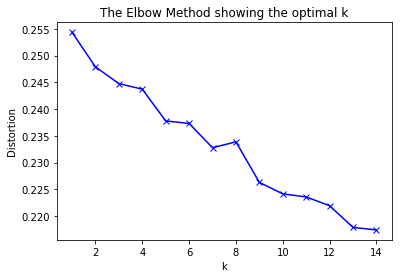

In [139]:
# Lets try Elbow method to see if we can find optimal number of clusters to use

distortions = []
K = range(1,15)
X = nyc_sfo_grouped_clustering
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [140]:
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_sfo_grouped_clustering)

# check labels created
kmeans.labels_[0:10]

array([3, 3, 7, 2, 2, 1, 7, 7, 7, 3], dtype=int32)

In [144]:
df.shape

(329, 4)

In [143]:
neighborhoods_venues_sorted.shape

(329, 12)

In [145]:
# create a new df with cluster labels added

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
nyc_sfo_merged = df

# merge with latitude/longitude for each neighborhood
nyc_sfo_merged = nyc_sfo_merged.join(neighborhoods_venues_sorted.set_index(['City','Neighborhood']), on=['City','Neighborhood'])

nyc_sfo_merged.head()

,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Richmond Valley,40.520105,-74.229311,New York,2,Train Station,Bank,Deli / Bodega,Fast Food Restaurant,Bus Stop,Flower Shop,Falafel Restaurant,Farm,Farmers Market,Field
1,Pleasant Plains,40.523994,-74.215700,New York,1,Donut Shop,Discount Store,Rental Car Location,Pizza Place,Fast Food Restaurant,Cosmetics Shop,Ice Cream Shop,Dessert Shop,Bank,Bar
2,Prince's Bay,40.528994,-74.197644,New York,7,Pizza Place,Sushi Restaurant,Italian Restaurant,Bank,Bagel Shop,Chinese Restaurant,Park,Liquor Store,Pharmacy,Football Stadium
3,Charleston,40.536772,-74.237367,New York,3,Restaurant,Construction & Landscaping,General Entertainment,German Restaurant,Music Venue,Child Care Service,Playground,Scenic Lookout,Liquor Store,Bakery
4,Huguenot,40.537328,-74.194588,New York,7,Train Station,Italian Restaurant,Movie Theater,Flea Market,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


In [147]:
# visualize nyc clusters

nyc_merged_clusters = nyc_sfo_merged[nyc_sfo_merged['City'] == 'New York']

nyc_map_clusters = folium.Map(location=[nyc_lat, nyc_lng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys))) 
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged_clusters['Latitude'], nyc_merged_clusters ['Longitude'], nyc_merged_clusters['Neighborhood'], nyc_merged_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.7).add_to(nyc_map_clusters)

nyc_map_clusters

In [148]:
# visualize sfo clusters

sfo_merged_clusters = nyc_sfo_merged[nyc_sfo_merged['City'] == 'San Francisco']

sfo_map_clusters = folium.Map(location=[sfo_lat, sfo_lng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys))) 
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sfo_merged_clusters['Latitude'], sfo_merged_clusters ['Longitude'], sfo_merged_clusters['Neighborhood'], sfo_merged_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.7).add_to(sfo_map_clusters)

sfo_map_clusters

In [149]:
sfo_merged_clusters['Cluster Labels'].unique()

array([2, 3, 5, 0, 7])

In [150]:
nyc_merged_clusters['Cluster Labels'].unique()

array([2, 1, 7, 3, 5, 0, 6, 8, 4])

In [ ]:
# cluster labels 0,2,3,5,7 map to both cities; examine the clusters

In [153]:
# cluster Label '0'
nyc_sfo_merged.loc[nyc_sfo_merged['Cluster Labels'] == 0, nyc_sfo_merged.columns[[3,0] + list(range(5, nyc_sfo_merged.shape[1]))]]

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,New York,Marine Park,Sandwich Place,Park,Zoo Exhibit,Flea Market,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
51,New York,Bayswater,Playground,Zoo Exhibit,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
131,New York,Middle Village,Playground,Tennis Court,Intersection,Park,Baseball Field,Farm,Farmers Market,Fast Food Restaurant,Field,Flea Market
175,New York,Little Neck,Chinese Restaurant,Sandwich Place,Zoo Exhibit,Flea Market,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
191,New York,Kensington,Park,Tennis Court,Flower Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
215,New York,Crotona Park,Park,Sandwich Place,Pizza Place,Tennis Court,Field,Fish & Chips Shop,Financial or Legal Service,Film Studio,Filipino Restaurant,Zoo Exhibit
245,New York,Fieldston,High School,Playground,Plaza,Bus Station,Zoo Exhibit,Fish Market,Factory,Falafel Restaurant,Farm,Farmers Market
248,New York,Riverdale,Gym,Wine Shop,Playground,Bus Station,Park,Shopping Mall,Farmers Market,Fast Food Restaurant,Farm,Field
267,San Francisco,Mount Davidson,Park,Tree,Monument / Landmark,Bus Line,Playground,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
272,San Francisco,Forest Hill,Playground,Park,French Restaurant,Japanese Restaurant,Hotpot Restaurant,Field,Financial or Legal Service,Film Studio,Filipino Restaurant,Zoo Exhibit


In [154]:
# cluster Label '2'
nyc_sfo_merged.loc[nyc_sfo_merged['Cluster Labels'] == 2, nyc_sfo_merged.columns[[3,0] + list(range(5, nyc_sfo_merged.shape[1]))]]

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,New York,Richmond Valley,Train Station,Bank,Deli / Bodega,Fast Food Restaurant,Bus Stop,Flower Shop,Falafel Restaurant,Farm,Farmers Market,Field
15,New York,Neponsit,Beach,Pizza Place,Bus Stop,Zoo Exhibit,Flower Shop,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
16,New York,Midland Beach,Deli / Bodega,Bus Stop,Baseball Field,Basketball Court,Chinese Restaurant,Smoke Shop,Café,Bookstore,Pet Store,Restaurant
20,New York,Manhattan Beach,Bus Stop,Café,Pizza Place,Sandwich Place,Food,Playground,Ice Cream Shop,Beach,Field,Fish & Chips Shop
39,New York,Dongan Hills,Pizza Place,Bus Stop,Bagel Shop,Diner,Flower Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
40,New York,Arrochar,Bus Stop,Pizza Place,Bagel Shop,Deli / Bodega,Flower Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
41,New York,Fort Wadsworth,Historic Site,Hotel,Food Truck,Bus Stop,Zoo Exhibit,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
45,New York,Grasmere,Supermarket,Cosmetics Shop,Gym / Fitness Center,Playground,Bus Stop,Pizza Place,Intersection,Park,Italian Restaurant,Peruvian Restaurant
49,New York,Concord,Train Station,Italian Restaurant,Park,Pizza Place,Automotive Shop,Bus Stop,Intersection,Gym / Fitness Center,Food Truck,Cosmetics Shop
50,New York,Emerson Hill,Intersection,Deli / Bodega,Lake,Automotive Shop,Zoo Exhibit,Filipino Restaurant,Fish Market,Fish & Chips Shop,Financial or Legal Service,Film Studio


In [155]:
# cluster Label '3'
nyc_sfo_merged.loc[nyc_sfo_merged['Cluster Labels'] == 3, nyc_sfo_merged.columns[[3,0] + list(range(5, nyc_sfo_merged.shape[1]))]]

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,New York,Charleston,Restaurant,Construction & Landscaping,General Entertainment,German Restaurant,Music Venue,Child Care Service,Playground,Scenic Lookout,Liquor Store,Bakery
10,New York,Bay Terrace,American Restaurant,Playground,Train Station,Performing Arts Venue,Food Truck,Financial or Legal Service,Film Studio,Filipino Restaurant,Zoo Exhibit,Fish Market
12,New York,Breezy Point,Trail,Monument / Landmark,Beach,Zoo Exhibit,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
14,New York,Oakwood,Shopping Mall,Pharmacy,Supplement Shop,Playground,Supermarket,Burger Joint,Furniture / Home Store,Sporting Goods Shop,Smoke Shop,Buffet
19,New York,Sea Gate,Optical Shop,Home Service,Gastropub,Bus Station,Beach,Spa,Fish Market,Falafel Restaurant,Farm,Farmers Market
22,New York,West Brighton,Aquarium,Gym,Theme Park Ride / Attraction,Movie Theater,Theme Park,Food Truck,Exhibit,Convenience Store,Bar,Breakfast Spot
24,New York,Brighton Beach,Grocery Store,Eastern European Restaurant,Mobile Phone Shop,Bakery,Café,Supermarket,Coffee Shop,Health & Beauty Service,Fast Food Restaurant,Theater
27,New York,Homecrest,Sushi Restaurant,Café,Ice Cream Shop,Market,Bagel Shop,Chinese Restaurant,Pizza Place,Gym,Maternity Clinic,Bank
28,New York,Ocean Breeze,Beach,Donut Shop,Gym / Fitness Center,Southern / Soul Food Restaurant,Market,Shoe Store,Pharmacy,Spa,Chinese Restaurant,Liquor Store
29,New York,South Beach,Baseball Field,Beach,Playground,Liquor Store,Deli / Bodega,Plaza,Supermarket,Food Truck,Bus Stop,Taco Place


In [156]:
# cluster Label '5'
nyc_sfo_merged.loc[nyc_sfo_merged['Cluster Labels'] == 5, nyc_sfo_merged.columns[[3,0] + list(range(5, nyc_sfo_merged.shape[1]))]]

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,New York,Woodrow,Home Service,Gift Shop,Flea Market,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
266,San Francisco,India Basin,Home Service,Zoo Exhibit,Flea Market,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


In [157]:
# cluster Label '7'
nyc_sfo_merged.loc[nyc_sfo_merged['Cluster Labels'] == 7, nyc_sfo_merged.columns[[3,0] + list(range(5, nyc_sfo_merged.shape[1]))]]

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,New York,Prince's Bay,Pizza Place,Sushi Restaurant,Italian Restaurant,Bank,Bagel Shop,Chinese Restaurant,Park,Liquor Store,Pharmacy,Football Stadium
4,New York,Huguenot,Train Station,Italian Restaurant,Movie Theater,Flea Market,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
6,New York,Annadale,Pizza Place,Restaurant,Construction & Landscaping,American Restaurant,Sushi Restaurant,Park,Bakery,Train Station,Bus Stop,Sports Bar
7,New York,Eltingville,Sushi Restaurant,Italian Restaurant,Pizza Place,Bank,Liquor Store,Pharmacy,Fast Food Restaurant,Diner,Coffee Shop,Sandwich Place
8,New York,Lindenwood,Bar,Pizza Place,Italian Restaurant,Sandwich Place,Cosmetics Shop,Bakery,Falafel Restaurant,Spanish Restaurant,Liquor Store,Train Station
9,New York,Great Kills,Italian Restaurant,Pizza Place,Deli / Bodega,Liquor Store,Nightclub,Bus Stop,Spanish Restaurant,Chinese Restaurant,Mexican Restaurant,Bar
11,New York,Rossville,Hardware Store,Grocery Store,Fruit & Vegetable Store,Pharmacy,Bagel Shop,Bar,Event Space,Chinese Restaurant,American Restaurant,Pizza Place
13,New York,Greenridge,Bagel Shop,Pizza Place,Bank,Video Game Store,Thrift / Vintage Store,Shopping Mall,Chinese Restaurant,Gym / Fitness Center,Pet Store,Coffee Shop
17,New York,New Dorp,Italian Restaurant,Sushi Restaurant,Indian Restaurant,Gas Station,Taco Place,Flower Shop,Chinese Restaurant,Mexican Restaurant,Bakery,Train Station
18,New York,Coney Island,Theme Park Ride / Attraction,Pizza Place,Deli / Bodega,Baseball Stadium,Bar,Hot Dog Joint,Caribbean Restaurant,Fast Food Restaurant,Brewery,Falafel Restaurant


In [158]:
#  review other labels that didn't cluster between the cities
# cluster Label '1'
nyc_sfo_merged.loc[nyc_sfo_merged['Cluster Labels'] == 1, nyc_sfo_merged.columns[[3,0] + list(range(5, nyc_sfo_merged.shape[1]))]]

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,New York,Pleasant Plains,Donut Shop,Discount Store,Rental Car Location,Pizza Place,Fast Food Restaurant,Cosmetics Shop,Ice Cream Shop,Dessert Shop,Bank,Bar
26,New York,Grant City,Convenience Store,Gym / Fitness Center,French Restaurant,Pharmacy,BBQ Joint,Automotive Shop,Fast Food Restaurant,Bank,Rental Car Location,Fountain
30,New York,Sheepshead Bay,Supermarket,Discount Store,Sandwich Place,Sushi Restaurant,Pharmacy,Chinese Restaurant,Liquor Store,Deli / Bodega,Bank,Convenience Store
33,New York,Arverne,Donut Shop,Deli / Bodega,Gas Station,Metro Station,Grocery Store,Beach,Playground,Sandwich Place,Film Studio,Fish & Chips Shop
38,New York,Edgemere,Chinese Restaurant,Metro Station,Grocery Store,Skate Park,Scenic Lookout,Supermarket,Fountain,Football Stadium,Eye Doctor,Fried Chicken Joint
42,New York,Todt Hill,Donut Shop,Mountain,Dog Run,Food,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio
47,New York,Far Rockaway,Pizza Place,Bank,Fried Chicken Joint,Donut Shop,Pharmacy,Chinese Restaurant,Fast Food Restaurant,Caribbean Restaurant,Grocery Store,Supermarket
57,New York,Midwood,Bakery,Donut Shop,Steakhouse,Grocery Store,Middle Eastern Restaurant,Bank,Bagel Shop,Pizza Place,Supermarket,Distillery
76,New York,Canarsie,Metro Station,Women's Store,Deli / Bodega,Caribbean Restaurant,Discount Store,Pharmacy,Restaurant,Sandwich Place,Martial Arts Dojo,Bagel Shop
79,New York,Starrett City,Supermarket,Moving Target,Bus Stop,Pharmacy,Donut Shop,Pizza Place,American Restaurant,Caribbean Restaurant,Bus Station,Fish & Chips Shop


In [159]:
# cluster Label '4'
nyc_sfo_merged.loc[nyc_sfo_merged['Cluster Labels'] == 4, nyc_sfo_merged.columns[[3,0] + list(range(5, nyc_sfo_merged.shape[1]))]]

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
74,New York,Port Ivory,Locksmith,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio


In [160]:
# cluster Label '6'
nyc_sfo_merged.loc[nyc_sfo_merged['Cluster Labels'] == 6, nyc_sfo_merged.columns[[3,0] + list(range(5, nyc_sfo_merged.shape[1]))]]

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,New York,Mill Basin,Pool,Zoo Exhibit,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


In [161]:
# cluster Label '8'
nyc_sfo_merged.loc[nyc_sfo_merged['Cluster Labels'] == 8, nyc_sfo_merged.columns[[3,0] + list(range(5, nyc_sfo_merged.shape[1]))]]

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,New York,Westerleigh,Arcade,Zoo Exhibit,Flower Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
